In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 520

ng =8

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 1000

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0 , 0.3 , 0.55/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

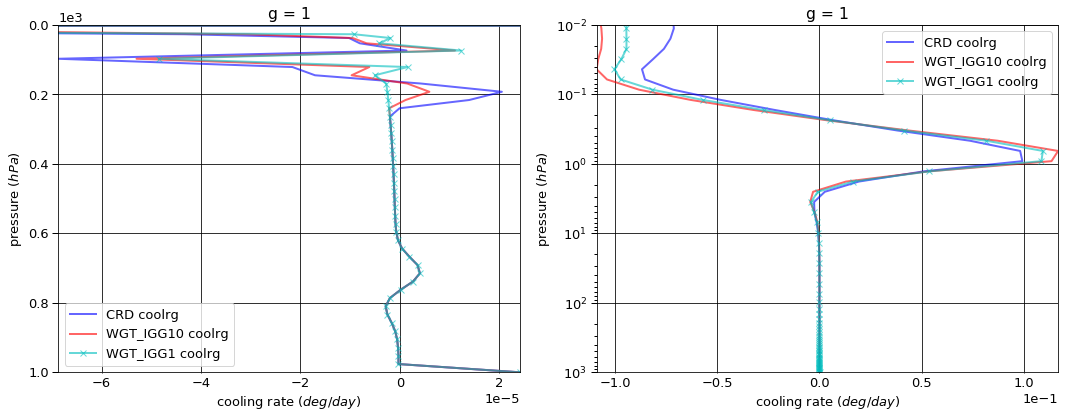

# Figure: cooling rate g-group 2

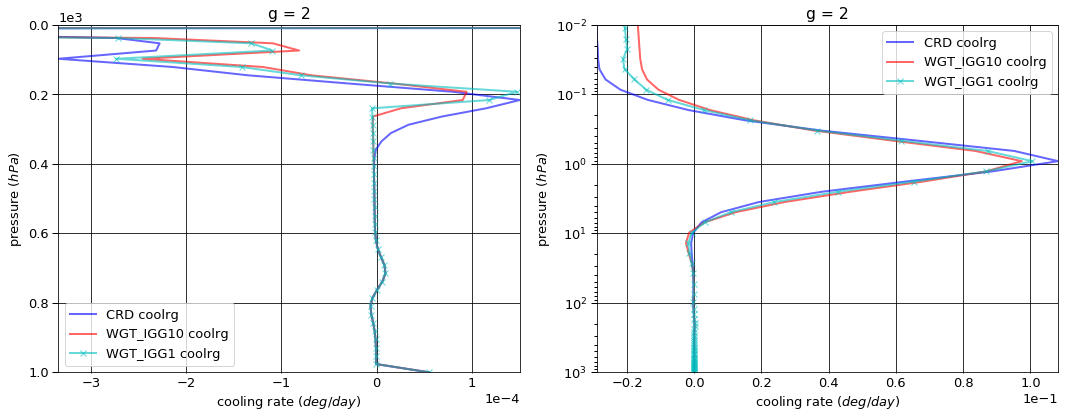

# Figure: cooling rate g-group 3

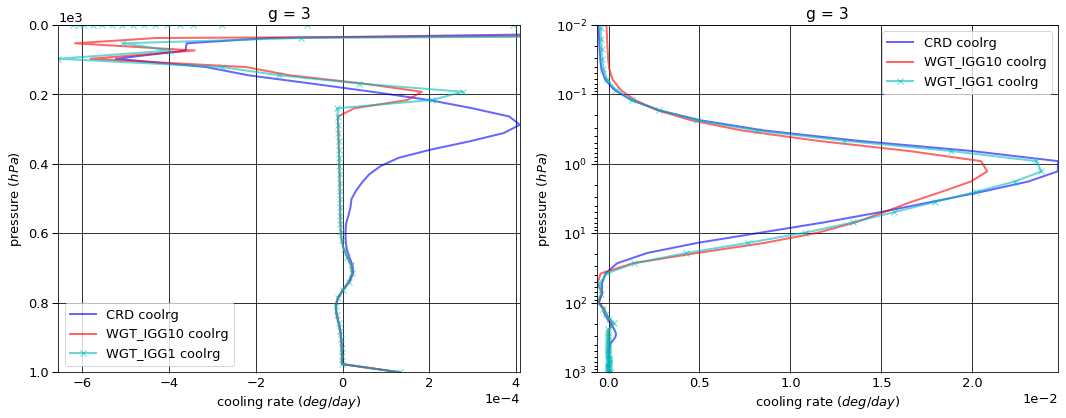

# Figure: cooling rate g-group 4

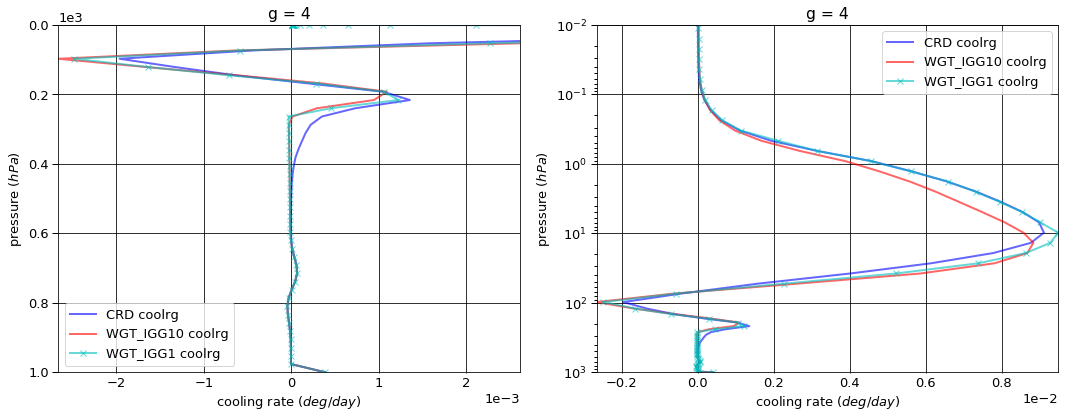

# Figure: cooling rate g-group 5

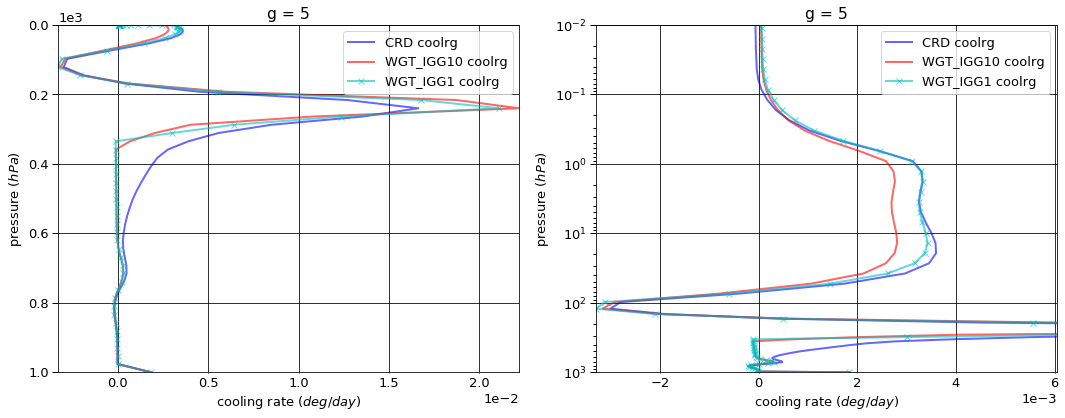

# Figure: cooling rate g-group 6

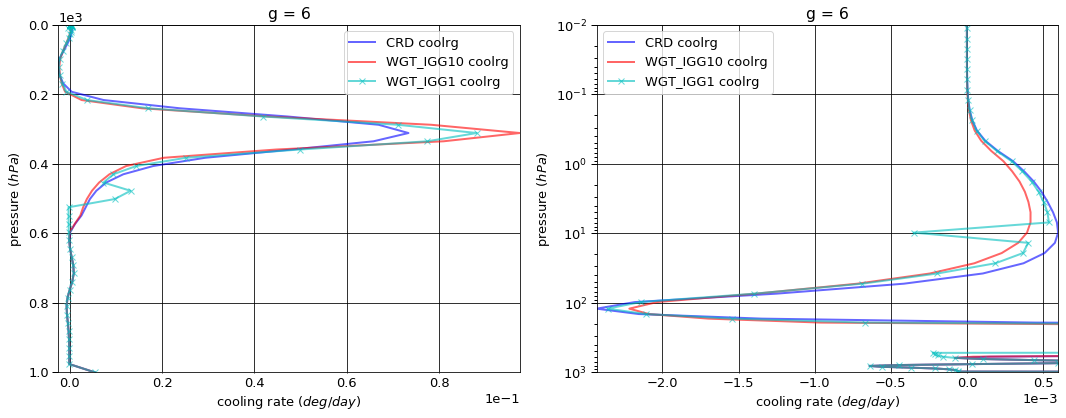

# Figure: cooling rate g-group 7

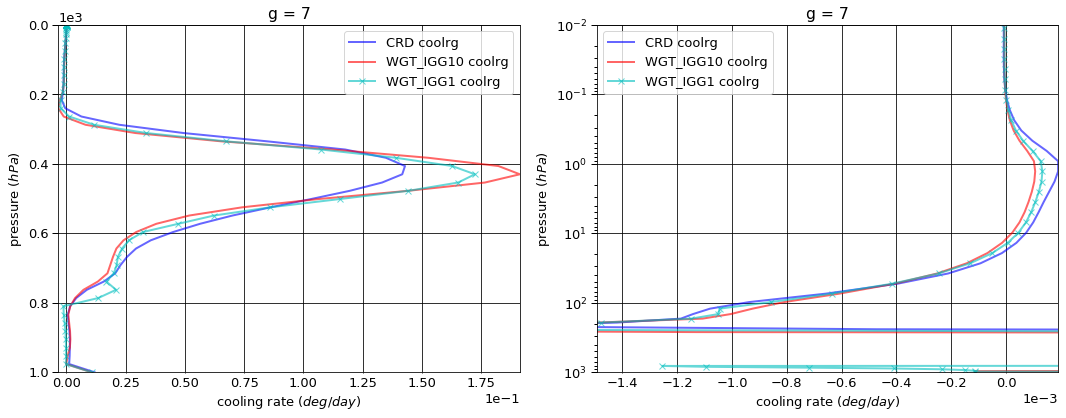

# Figure: cooling rate g-group 8

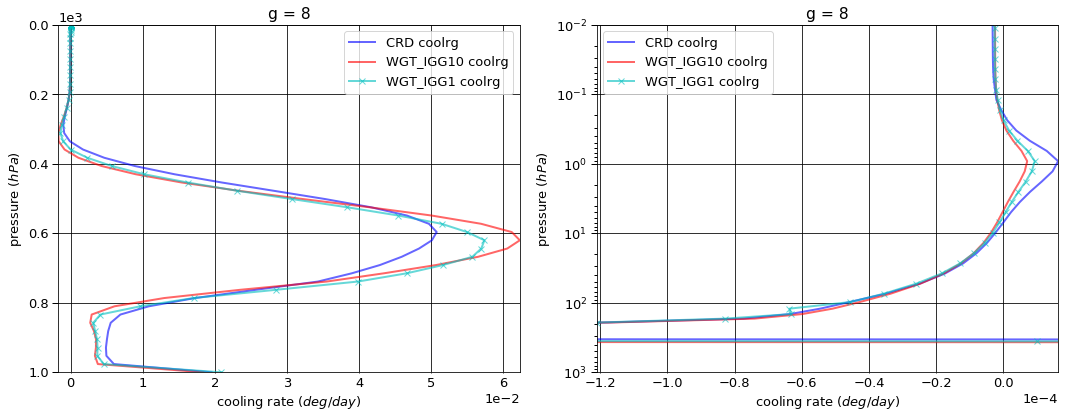

# Figure: cooling rate g-group total

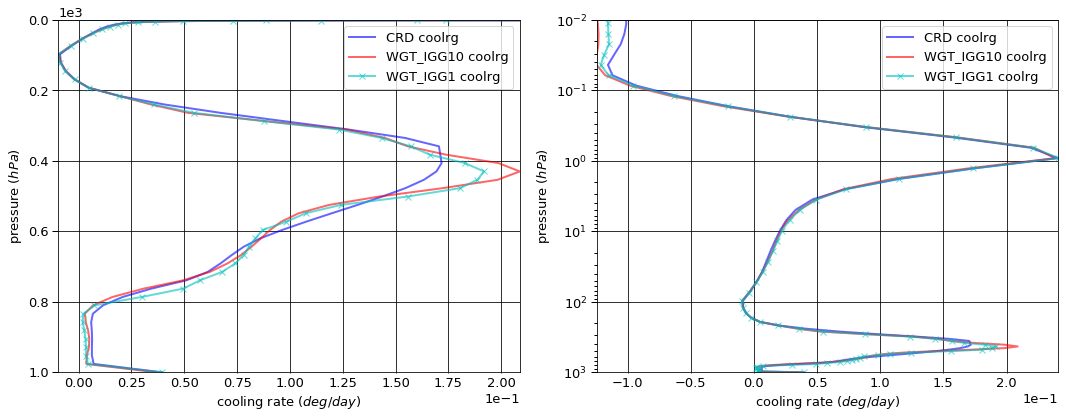

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009101   0.000000 -0.009101
  1013.0   76     -0.040341   0.040272 -0.000068
2 0.0      1      -0.021891   0.000000 -0.021891
  1013.0   76     -0.091678   0.091522 -0.000155
3 0.0      1      -0.026684   0.000000 -0.026684
  1013.0   76     -0.220321   0.219946 -0.000374
4 0.0      1      -0.039394   0.000000 -0.039394
  1013.0   76     -0.646072   0.644976 -0.001096
5 0.0      1      -0.236149   0.000000 -0.236149
  1013.0   76     -3.059449   3.054207 -0.005243
6 0.0      1      -1.182032   0.000000 -1.182032
  1013.0   76     -9.057670   9.042284 -0.015386
7 0.0      1      -4.223147   0.000000 -4.223147
  1013.0   76    -17.883031  17.850847 -0.032184
8 0.0      1      -1.954859   0.000000 -1.954859
  1013.0   76     -4.856472   4.792819 -0.063653


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009180   0.000000 -0.009180
  1013.0   76     -0.040341   0.040272 -0.000068
2 0.0      1      -0.023131   0.000000 -0.023131
  1013.0   76     -0.091678   0.091522 -0.000155
3 0.0      1      -0.025338   0.000000 -0.025338
  1013.0   76     -0.220321   0.219946 -0.000374
4 0.0      1      -0.036912   0.000000 -0.036912
  1013.0   76     -0.646072   0.644976 -0.001096
5 0.0      1      -0.181719   0.000000 -0.181719
  1013.0   76     -3.059449   3.054263 -0.005187
6 0.0      1      -1.198711   0.000000 -1.198711
  1013.0   76     -9.057670   9.042284 -0.015386
7 0.0      1      -4.230692   0.000000 -4.230692
  1013.0   76    -17.883031  17.852852 -0.030178
8 0.0      1      -1.966418   0.000000 -1.966418
  1013.0   76     -4.856472   4.806457 -0.050015


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009162   0.000000 -0.009162
  1013.0   76     -0.040341   0.040272 -0.000068
2 0.0      1      -0.022661   0.000000 -0.022661
  1013.0   76     -0.091678   0.091522 -0.000155
3 0.0      1      -0.025607   0.000000 -0.025607
  1013.0   76     -0.220321   0.219946 -0.000374
4 0.0      1      -0.037532   0.000000 -0.037532
  1013.0   76     -0.646072   0.644976 -0.001096
5 0.0      1      -0.186176   0.000000 -0.186176
  1013.0   76     -3.059449   3.054263 -0.005187
6 0.0      1      -1.205988   0.000000 -1.205988
  1013.0   76     -9.057670   9.042284 -0.015386
7 0.0      1      -4.273886   0.000000 -4.273886
  1013.0   76    -17.883031  17.852852 -0.030178
8 0.0      1      -1.984164   0.000000 -1.984164
  1013.0   76     -4.856472   4.797284 -0.059188


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -7.884100e-05  0.000000 -7.884100e-05
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -1.239125e-03  0.000000 -1.239125e-03
  1013.0   76     1.387779e-17  0.000000  0.000000e+00
3 0.0      1      1.345659e-03  0.000000  1.345659e-03
  1013.0   76     0.000000e+00  0.000000 -5.421011e-20
4 0.0      1      2.481496e-03  0.000000  2.481496e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
5 0.0      1      5.442999e-02  0.000000  5.442999e-02
  1013.0   76     0.000000e+00  0.000056  5.553520e-05
6 0.0      1     -1.667980e-02  0.000000 -1.667980e-02
  1013.0   76    -1.776357e-15  0.000000  0.000000e+00
7 0.0      1     -7.545300e-03  0.000000 -7.545300e-03
  1013.0   76     0.000000e+00  0.002005  2.005548e-03
8 0.0      1     -1.155890e-02  0.000000 -1.155890e-02
  1013.0   76    -8.881784e-16  0.013638  1.363748e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1     -6.046760e-05  0.000000 -6.046760e-05
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -7.695310e-04  0.000000 -7.695310e-04
  1013.0   76     1.387779e-17  0.000000  0.000000e+00
3 0.0      1      1.076905e-03  0.000000  1.076905e-03
  1013.0   76     0.000000e+00  0.000000 -5.421011e-20
4 0.0      1      1.861724e-03  0.000000  1.861724e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
5 0.0      1      4.997287e-02  0.000000  4.997287e-02
  1013.0   76     0.000000e+00  0.000056  5.553520e-05
6 0.0      1     -2.395660e-02  0.000000 -2.395660e-02
  1013.0   76    -1.776357e-15  0.000000  0.000000e+00
7 0.0      1     -5.073870e-02  0.000000 -5.073870e-02
  1013.0   76     0.000000e+00  0.002005  2.005549e-03
8 0.0      1     -2.930440e-02  0.000000 -2.930440e-02
  1013.0   76    -8.881784e-16  0.004465  4.464477e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.555547e-02
  1001.112500 75     2.415395e-05
2 0.000312    1     -3.098242e-02
  1001.112500 75     5.485877e-05
3 0.000312    1     -7.514086e-04
  1001.112500 75     1.321281e-04
4 0.000312    1     -1.226054e-05
  1001.112500 75     3.866692e-04
5 0.000312    1     -9.265052e-05
  1001.112500 75     1.853812e-03
6 0.000312    1     -8.564454e-07
  1001.112500 75     5.429627e-03
7 0.000312    1     -1.014656e-05
  1001.112500 75     1.192622e-02
8 0.000312    1     -3.340449e-06
  1001.112500 75     1.954887e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.197450e-01
  1001.112500 75     2.415395e-05
2 0.000312    1     -1.816267e-02
  1001.112500 75     5.485877e-05
3 0.000312    1     -2.886485e-04
  1001.112500 75     1.321281e-04
4 0.000312    1      9.356401e-06
  1001.112500 75     3.866692e-04
5 0.000312    1      2.493124e-05
  1001.112500 75     1.830566e-03
6 0.000312    1     -8.622513e-07
  1001.112500 75     5.429627e-03
7 0.000312    1     -7.328803e-06
  1001.112500 75     1.065114e-02
8 0.000312    1     -2.505927e-06
  1001.112500 75     1.840496e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.059841e-01
  1001.112500 75     2.415395e-05
2 0.000312    1     -2.228801e-02
  1001.112500 75     5.485877e-05
3 0.000312    1     -6.211870e-04
  1001.112500 75     1.321281e-04
4 0.000312    1      3.932307e-06
  1001.112500 75     3.866692e-04
5 0.000312    1      3.363454e-05
  1001.112500 75     1.830566e-03
6 0.000312    1     -7.337701e-07
  1001.112500 75     5.429627e-03
7 0.000312    1     -7.484681e-06
  1001.112500 75     1.065114e-02
8 0.000312    1     -2.629104e-06
  1001.112500 75     2.091992e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.418948e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.281975e-02
  1001.112500 75    -6.776264e-21
3 0.000312    1      4.627600e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      2.161694e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      1.175818e-04
  1001.112500 75    -2.324650e-05
6 0.000312    1     -5.805950e-09
  1001.112500 75     0.000000e+00
7 0.000312    1      2.817761e-06
  1001.112500 75    -1.275083e-03
8 0.000312    1      8.345215e-07
  1001.112500 75    -1.143911e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.042867e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      8.694406e-03
  1001.112500 75    -6.776264e-21
3 0.000312    1      1.302216e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      1.619285e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      1.262851e-04
  1001.112500 75    -2.324650e-05
6 0.000312    1      1.226753e-07
  1001.112500 75     0.000000e+00
7 0.000312    1      2.661883e-06
  1001.112500 75    -1.275083e-03
8 0.000312    1      7.113448e-07
  1001.112500 75     1.371050e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.693258,0.000000,-7.693258
1013.0,76,-35.855033,35.736874,-0.118159



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.672102,0.000000,-7.672102
1013.0,76,-35.855033,35.752572,-0.102461



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.745176,0.000000,-7.745176
1013.0,76,-35.855033,35.743399,-0.111634



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.115518e-02,0.000000,0.021155
1013.0,76,-7.105427e-15,0.015698,0.015699



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.191820e-02,0.000000,-0.051918
1013.0,76,-7.105427e-15,0.006525,0.006526


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.117409
1001.112500,75,0.039356



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.138173
1001.112500,75,0.036914



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.128867
1001.112500,75,0.039429



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.020764
1001.112500,75,-0.002442



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.011458
1001.112500,75,0.000073


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.017237,0.017975
5,0.081883,0.085181
6,0.244898,0.251475
7,0.483221,0.502779
8,0.163183,0.132796


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,1.255473e-20
5,8.096279e-22
6,2.585158e-21
7,1.675857e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009792,1.0
4,1.255473e-20,0.641708,0.017237,0.017975,0.026815,0.027768,10.0
5,8.096279e-22,0.064488,0.081883,0.085181,0.108698,0.112949,10.0
6,2.585158e-21,3.193020,0.244898,0.251475,0.353596,0.364424,500.0
7,1.675857e-22,0.064826,0.483221,0.502779,0.836817,0.867204,500.0
8,1.086393e-23,0.064826,0.163183,0.132796,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.661643e-17  8.682991e-18   1.913675  9.027238e-04
      2 0.000312     9.970814e-19  4.472716e-19   2.229253  5.187203e-05
      3 0.000312     2.730384e-20  1.157183e-20   2.359510  1.725964e-06
      4 0.000312     4.015752e-22  2.842037e-22   1.412984  2.656817e-08
      5 0.000312     2.651686e-22  7.153119e-23   3.707035  1.633816e-08
      6 0.000312     1.253356e-24  1.197599e-24   1.046557  8.286598e-11
      7 0.000312     2.688125e-24  1.315966e-24   2.042701  1.195395e-10
      8 0.000312     1.706424e-24  1.922091e-25   8.877951  7.092514e-11
2     1 0.000750     1.661412e-17  8.692895e-18   1.911230  3.636940e-04
      2 0.000750     1.000212e-18  4.487472e-19   2.228898  2.095985e-05
      3 0.000750     2.744925e-20  1.162629e-20   2.360964  6.988674e-07
      4 0.000750     4.053112e-22  2.874538e-22   1.410005  1.080340e-08
      5 0.000750     2.658591e-22  7.182318e-23   3.701578  6.598371e-09
      6 0.000750     1.268758e-24  1.212711e-24   1.046216  3.379850e-11
      7 0.000750     2.697836e-24  1.321375e-24   2.041689  4.833564e-11
      8 0.000750     1.709445e-24  1.928299e-25   8.865040  2.862180e-11
3     1 0.001052     1.660959e-17  8.712843e-18   1.906334  5.102926e-04
      2 0.001052     1.006518e-18  4.516870e-19   2.228354  2.958108e-05
      3 0.001052     2.772985e-20  1.171761e-20   2.366511  9.899392e-07
      4 0.001052     4.102699e-22  2.914693e-22   1.407592  1.533880e-08
      5 0.001052     2.671115e-22  7.224344e-23   3.697381  9.297533e-09
      6 0.001052     1.287557e-24  1.230942e-24   1.045993  4.811107e-11
      7 0.001052     2.716365e-24  1.331111e-24   2.040674  6.826886e-11
      8 0.001052     1.715527e-24  1.939694e-25   8.844319  4.028960e-11
4     1 0.001476     1.660477e-17  8.732928e-18   1.901397  7.162357e-04
      2 0.001476     1.012936e-18  4.546896e-19   2.227753  4.176669e-05
      3 0.001476     2.802069e-20  1.181560e-20   2.371499  1.403139e-06
      4 0.001476     4.158839e-22  2.961235e-22   1.404427  2.181862e-08
      5 0.001476     2.684326e-22  7.270575e-23   3.692040  1.310881e-08
      6 0.001476     1.309344e-24  1.252144e-24   1.045682  6.865717e-11
      7 0.001476     2.735679e-24  1.341357e-24   2.039486  9.648477e-11
      8 0.001476     1.721842e-24  1.951555e-25   8.822922  5.674164e-11
5     1 0.002070     1.659970e-17  8.752876e-18   1.896485  1.005059e-03
      2 0.002070     1.019383e-18  4.577198e-19   2.227089  5.895895e-05
      3 0.002070     2.831943e-20  1.192090e-20   2.375612  1.988768e-06
      4 0.002070     4.223269e-22  3.016128e-22   1.400229  3.108702e-08
      5 0.002070     2.698202e-22  7.322027e-23   3.685048  1.848289e-08
      6 0.002070     1.335013e-24  1.277217e-24   1.045251  9.822595e-11
      7 0.002070     2.755652e-24  1.352099e-24   2.038055  1.363674e-10
      8 0.002070     1.728321e-24  1.963838e-25   8.800730  7.990165e-11
6     1 0.002904     1.659436e-17  8.772679e-18   1.891596  1.410479e-03
      2 0.002904     1.025861e-18  4.607836e-19   2.226340  8.323706e-05
      3 0.002904     2.862790e-20  1.203574e-20   2.378574  2.819864e-06
      4 0.002904     4.299094e-22  3.082438e-22   1.394706  4.440952e-08
      5 0.002904     2.712933e-22  7.380723e-23   3.675700  2.607122e-08
      6 0.002904     1.366049e-24  1.307646e-24   1.044663  1.410678e-10
      7 0.002904     2.776444e-24  1.363491e-24   2.036275  1.928209e-10
      8 0.002904     1.734981e-24  1.976686e-25   8.777221  1.125386e-10
7     1 0.004074     1.658871e-17  8.792335e-18   1.886724  1.979450e-03
      2 0.004074     1.032377e-18  4.638901e-19   2.225478  1.175167e-04
      3 0.004074     2.894874e-20  1.216384e-20   2.379902  3.999809e-06
      4 0.004074     4.390677e-22  3.164544e-22   1.387460  6.366093e-08
      5 0.004074     2.728786e-22  7.449526e-23   3.663032  3.679155e-08
      6 0.0

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
